### Import python packages

In [2]:
import pandas as pd
import numpy as np
import json
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

### Take a look at influencer dataset in fashion category

In [43]:
influencer_df = pd.read_csv('fashion_influencer.csv', index_col=0)
influencer_df = influencer_df.rename(columns={"Sponser": "Sponsor"})

In [44]:
user_df = influencer_df.groupby('Username').count()
user_df

,Sponsor,json_file,image_files,#Followers,#Followees,#Posts
Username,,,,,,
1000manerasdevestir,85,85,85,85,85,85
19dreamcatcherz,9,9,9,9,9,9
1_0.8,5,5,5,5,5,5
1nonlycash,4,4,4,4,4,4
22in22,11,11,11,11,11,11
...,...,...,...,...,...,...
zsuzsubell,12,12,12,12,12,12
zubiiansarii,40,40,40,40,40,40
zurich.influencers,13,13,13,13,13,13


In [45]:
print("There are \'", user_df.shape[0], "\' influencers in the dataset")

There are ' 9290 ' influencers in the dataset


In [46]:
user_sponsor = influencer_df[['Username', 'Sponsor']]
user_sponsor['Sponsor'].value_counts()

0    550050
1     88691
Name: Sponsor, dtype: int64

In [47]:
sponsor_info = user_sponsor.groupby('Username')['Sponsor'].value_counts().unstack(fill_value=0).reset_index()
sponsor_info = sponsor_info.rename(columns={0: 'non-sponsored', 1: 'sponsored'})
sponsor_info['percentage_of_sponsored'] = sponsor_info['sponsored']/(sponsor_info['non-sponsored']+sponsor_info['sponsored'])
sponsor_info.sort_values('percentage_of_sponsored', ascending=False)

Sponsor,Username,non-sponsored,sponsored,percentage_of_sponsored
1729,dancelizz,0,1,1.0
3559,josiedoy,0,1,1.0
4825,malaneenee23,0,2,1.0
3650,junnyykpaw,0,2,1.0
3330,jazzbubbles,0,1,1.0
...,...,...,...,...
8559,typical_audrey,17,0,0.0
4384,lilimakes,52,0,0.0
7080,shuchitasharan,6,0,0.0
7078,showbiz_buzz,94,0,0.0


In [48]:
sponsor_info['percentage_of_sponsored'].value_counts()

0.000000    1011
0.166667     127
0.250000     123
0.142857     119
0.200000     116
            ... 
0.061069       1
0.156463       1
0.201681       1
0.546154       1
0.073593       1
Name: percentage_of_sponsored, Length: 2274, dtype: int64

### Json preprocessing and take a look at post data

In [49]:
# dir: the directory where those json files are stored in, make sure to use the right input
# json_list: the list of json files that you want to merged (the list file name should contain '.json')
#
# One issue: the amount of comments sometimes don't fit with the lenth of edge
def process_json_files(dir, json_list):
    df_list = []
    for i in json_list:
        data = []          
        content = json.load(open(os.path.join(dir, i)))
        data.append({
            'json': i,
            'post_timestamp': content['taken_at_timestamp'],
            'likes': content['edge_media_preview_like']['count'],
            'comments': content['edge_media_to_comment']['count'],
            # 'post_text': content['edge_media_to_caption']['edges'][0]['node']['text'],
            'edge_media_to_comment': content.get('edge_media_to_comment').get('edges'),
            'edge_media_to_sponsor_user': content.get('edge_media_to_sponsor_user'),
            'edge_media_to_tagged_user': content.get('edge_media_to_tagged_user')
        })
        df_list.append(pd.DataFrame(data))
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [50]:
# Define the folder path
folder_path = "json"

# List to store all file names
all_files = []
files_name = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
  # Append all filenames to the list
  all_files.append(filename)

# Print the list of all files
for file in all_files:
  files_name.append(file)

In [52]:
# an example, more info can be added to the column if needed
# '1496692483702070013.json', '2035014620515122637.json'
post_df = process_json_files('json', files_name)
post_df

,json,post_timestamp,likes,comments,edge_media_to_comment,edge_media_to_sponsor_user,edge_media_to_tagged_user
0,1778527492682732179.json,1526237020,172,11,None,None,None
1,1944636038815427244.json,1546038702,259,6,"[{'node': {'created_at': 1546040209, 'did_repo...",{'edges': []},{'edges': [{'node': {'user': {'full_name': 'Av...
2,1919337317395337083.json,1543022859,3191,39,None,None,None
3,1973686443494832201.json,1549501780,3217,69,None,None,None
4,1687821871570856682.json,1515424067,1268,88,None,None,None
...,...,...,...,...,...,...,...
425606,1938593043369662682.json,1545318321,11094,18,"[{'node': {'created_at': 1545318570, 'did_repo...",{'edges': []},{'edges': [{'node': {'user': {'full_name': 'UN...
425607,2002986686942145187.json,1552994641,547,20,None,None,None
425608,1867448645486726111.json,1536837248,451,80,None,None,None
425609,1459428168212777165.json,1488197416,187,29,None,None,None


In [53]:
influencer_df_extracted = influencer_df[['json_file', 'Username', 'Sponsor','#Followers', '#Posts']]
post_df_extracted = post_df[['json', 'post_timestamp', 'likes','comments']]

### Merge influencer and post dataframe, calculate engagement rate (ER), and do preprocessing
#### ER = (likes + comments) / followers

In [60]:
merged = pd.merge(left=post_df_extracted, right=influencer_df_extracted, left_on='json', right_on='json_file')
merged = merged.drop(columns=['json_file', 'json'])
merged

In [62]:
merged['ER'] = (merged['likes'] + merged['comments'])/merged['#Followers']
merged

,post_timestamp,likes,comments,Username,Sponsor,#Followers,#Posts,ER
0,1526237020,172,11,layersnlipstick,0,3105.0,1652.0,0.058937
1,1546038702,259,6,madison_silotti,0,4937.0,805.0,0.053676
2,1543022859,3191,39,mrs.rebeccarobinson,0,83376.0,1468.0,0.038740
3,1549501780,3217,69,thehouseofsequins,0,225990.0,2451.0,0.014540
4,1515424067,1268,88,scoynex,0,34957.0,799.0,0.038791
...,...,...,...,...,...,...,...,...
425606,1545318321,11094,18,jeromelamaar,0,232436.0,977.0,0.047807
425607,1552994641,547,20,mrscocowyse,0,110414.0,4267.0,0.005135
425608,1536837248,451,80,jennaleeannllc,0,9110.0,561.0,0.058288
425609,1488197416,187,29,laura.lehman,0,11388.0,810.0,0.018967


In [67]:
COLUMN = ['post_timestamp', 'likes', 'comments', 'Sponsor', 'ER']
df_ = merged[COLUMN]

In [68]:
# Check data types and missing values
print(df_.info())

# Descriptive statistics for numerical columns
print(df_.describe())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 425611 entries, 0 to 425610
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   post_timestamp  425611 non-null  int64  
 1   likes           425611 non-null  int64  
 2   comments        425611 non-null  int64  
 3   Sponsor         425611 non-null  int64  
 4   ER              425611 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 19.5 MB
None
       post_timestamp         likes       comments        Sponsor  \
count    4.256110e+05  4.256110e+05  425611.000000  425611.000000   
mean     1.532124e+09  4.913598e+03      89.823954       0.134703   
std      1.799305e+07  3.710753e+04     807.674569       0.341406   
min      1.350679e+09  0.000000e+00       0.000000       0.000000   
25%      1.523614e+09  3.730000e+02      15.000000       0.000000   
50%      1.535981e+09  9.320000e+02      38.000000       0.000000   
75%      1.544991e+09  2.4600

In [69]:
df_['post_timestamp'] = df_['post_timestamp'].apply(lambda d:dt.datetime.fromtimestamp(d).strftime('%Y-%m-%d %H:%M:%S'))

df_.sort_values('post_timestamp')

/var/folders/c_/6jt_vlf55f91p67q18x96hlr0000gn/T/ipykernel_28427/996440973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['post_timestamp'] = df_['post_timestamp'].apply(lambda d:dt.datetime.fromtimestamp(d).strftime('%Y-%m-%d %H:%M:%S'))


,post_timestamp,likes,comments,Sponsor,ER
0,2018-05-13 14:43:40,172,11,0,0.058937
1,2018-12-28 18:11:42,259,6,0,0.053676
2,2018-11-23 20:27:39,3191,39,0,0.038740
3,2019-02-06 20:09:40,3217,69,0,0.014540
4,2018-01-08 10:07:47,1268,88,0,0.038791
...,...,...,...,...,...
425606,2018-12-20 10:05:21,11094,18,0,0.047807
425607,2019-03-19 07:24:01,547,20,0,0.005135
425608,2018-09-13 07:14:08,451,80,0,0.058288
425609,2017-02-27 07:10:16,187,29,0,0.018967


In [71]:
# Convert timestamp to datetime
df_['post_timestamp'] = pd.to_datetime(df_['post_timestamp'])

# Extract year, month, day, hour
df_['year'] = df_['post_timestamp'].dt.year
df_['month'] = df_['post_timestamp'].dt.month
df_['day'] = df_['post_timestamp'].dt.day
df_['hour'] = df_['post_timestamp'].dt.hour
df_['minute'] = df_['post_timestamp'].dt.minute
df_['second'] = df_['post_timestamp'].dt.second


df_

/var/folders/c_/6jt_vlf55f91p67q18x96hlr0000gn/T/ipykernel_28427/3486160260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['post_timestamp'] = pd.to_datetime(df_['post_timestamp'])
/var/folders/c_/6jt_vlf55f91p67q18x96hlr0000gn/T/ipykernel_28427/3486160260.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['year'] = df_['post_timestamp'].dt.year
/var/folders/c_/6jt_vlf55f91p67q18x96hlr0000gn/T/ipykernel_28427/3486160260.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

,post_timestamp,likes,comments,Sponsor,ER,year,month,day,hour,minute,second
0,2018-05-13 14:43:40,172,11,0,0.058937,2018,5,13,14,43,40
1,2018-12-28 18:11:42,259,6,0,0.053676,2018,12,28,18,11,42
2,2018-11-23 20:27:39,3191,39,0,0.038740,2018,11,23,20,27,39
3,2019-02-06 20:09:40,3217,69,0,0.014540,2019,2,6,20,9,40
4,2018-01-08 10:07:47,1268,88,0,0.038791,2018,1,8,10,7,47
...,...,...,...,...,...,...,...,...,...,...,...
425606,2018-12-20 10:05:21,11094,18,0,0.047807,2018,12,20,10,5,21
425607,2019-03-19 07:24:01,547,20,0,0.005135,2019,3,19,7,24,1
425608,2018-09-13 07:14:08,451,80,0,0.058288,2018,9,13,7,14,8
425609,2017-02-27 07:10:16,187,29,0,0.018967,2017,2,27,7,10,16


### Exploratory data analysis and visualization

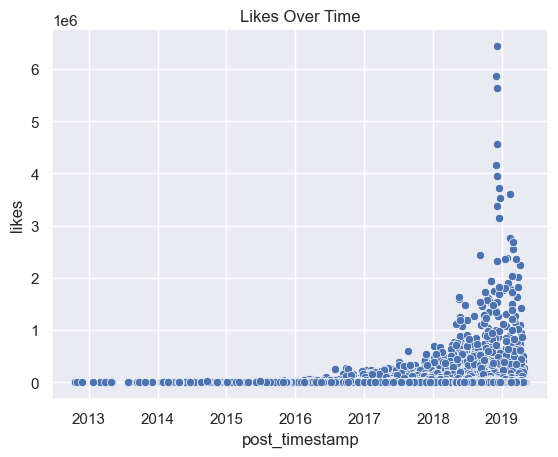

In [80]:
# Time series plot
sns.scatterplot(x='post_timestamp', y='likes', data=df_)
plt.title('Likes Over Time')
plt.grid(True)
plt.show()

In [81]:
toplike = df_.sort_values(by='likes', ascending=False).head(100)
toplike

,post_timestamp,likes,comments,Sponsor,ER,year,month,day,hour,minute,second
236663,2018-12-04 07:36:17,6435680,58870,0,0.226827,2018,12,4,7,36,17
134302,2018-12-01 10:31:57,5854953,60291,0,0.206594,2018,12,1,10,31,57
382023,2018-12-04 07:35:14,5628253,42360,0,0.198050,2018,12,4,7,35,14
28717,2018-12-04 10:12:50,4564501,74667,0,0.162026,2018,12,4,10,12,50
109148,2018-12-02 07:57:01,4154532,38465,0,0.146444,2018,12,2,7,57,1
...,...,...,...,...,...,...,...,...,...,...,...
368111,2018-07-12 21:27:05,820391,3060,0,0.028760,2018,7,12,21,27,5
180287,2018-11-09 18:22:37,810701,10616,0,0.161854,2018,11,9,18,22,37
302434,2019-03-19 12:13:56,797800,1823,0,0.027927,2019,3,19,12,13,56
127913,2018-05-27 16:36:43,790472,5154,0,0.071733,2018,5,27,16,36,43


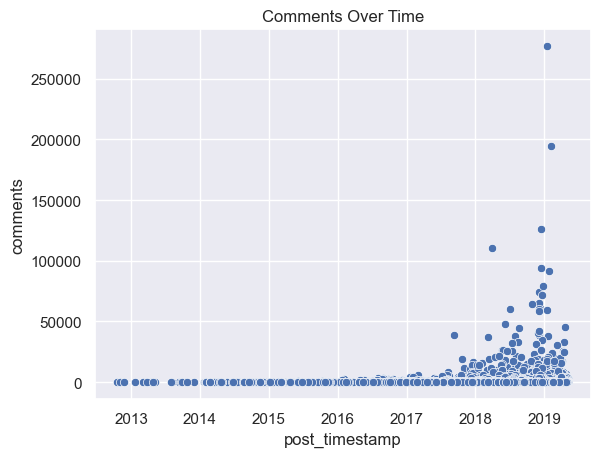

In [82]:
# Time series plot
sns.scatterplot(x='post_timestamp', y='comments', data=df_)
plt.title('Comments Over Time')
plt.grid(True)
plt.show()

In [83]:
topcomment = df_.sort_values(by='comments', ascending=False).head(100)
topcomment

,post_timestamp,likes,comments,Sponsor,ER,year,month,day,hour,minute,second
289560,2019-01-15 14:48:23,98271,276875,0,0.743172,2019,1,15,14,48,23
197306,2019-02-04 13:53:01,25967,194996,1,1.465816,2019,2,4,13,53,1
14833,2018-12-16 15:07:32,86877,126250,0,0.247600,2018,12,16,15,7,32
182775,2018-03-27 16:49:18,174440,110194,0,0.044268,2018,3,27,16,49,18
47163,2018-12-13 15:16:27,175118,94379,0,0.098901,2018,12,13,15,16,27
...,...,...,...,...,...,...,...,...,...,...,...
340659,2019-02-26 07:40:20,28983,13479,0,0.391705,2019,2,26,7,40,20
297000,2018-12-18 08:43:45,3727661,13354,0,0.130658,2018,12,18,8,43,45
312301,2018-12-07 12:16:06,3948666,13306,0,0.138375,2018,12,7,12,16,6
149343,2019-02-19 14:36:23,38618,13130,0,0.060118,2019,2,19,14,36,23


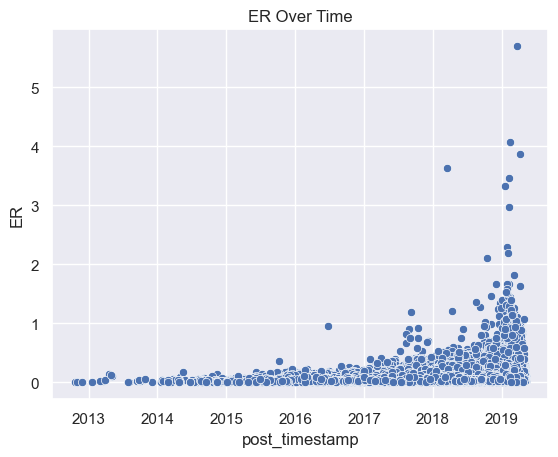

In [84]:
# Time series plot
sns.scatterplot(x='post_timestamp', y='ER', data=df_)
plt.title('ER Over Time')
plt.grid(True)
plt.show()

In [85]:
topER = df_.sort_values(by='ER', ascending=False).head(100)
topER

,post_timestamp,likes,comments,Sponsor,ER,year,month,day,hour,minute,second
311733,2019-03-21 01:56:31,16156,5,1,5.692497,2019,3,21,1,56,31
118978,2019-02-13 17:43:34,185413,313,0,4.074636,2019,2,13,17,43,34
266234,2019-04-05 16:59:51,4640,44,0,3.871074,2019,4,5,16,59,51
289594,2018-03-18 19:17:28,50076,207,0,3.633690,2018,3,18,19,17,28
357213,2019-02-07 18:50:37,157109,241,0,3.452096,2019,2,7,18,50,37
...,...,...,...,...,...,...,...,...,...,...,...
111201,2019-03-24 17:56:21,4027,291,0,0.879251,2019,3,24,17,56,21
312613,2019-03-30 19:33:46,3948,364,0,0.878029,2019,3,30,19,33,46
244751,2019-01-11 20:06:47,3779,524,1,0.876196,2019,1,11,20,6,47
341928,2019-03-28 15:22:53,3953,335,0,0.873142,2019,3,28,15,22,53


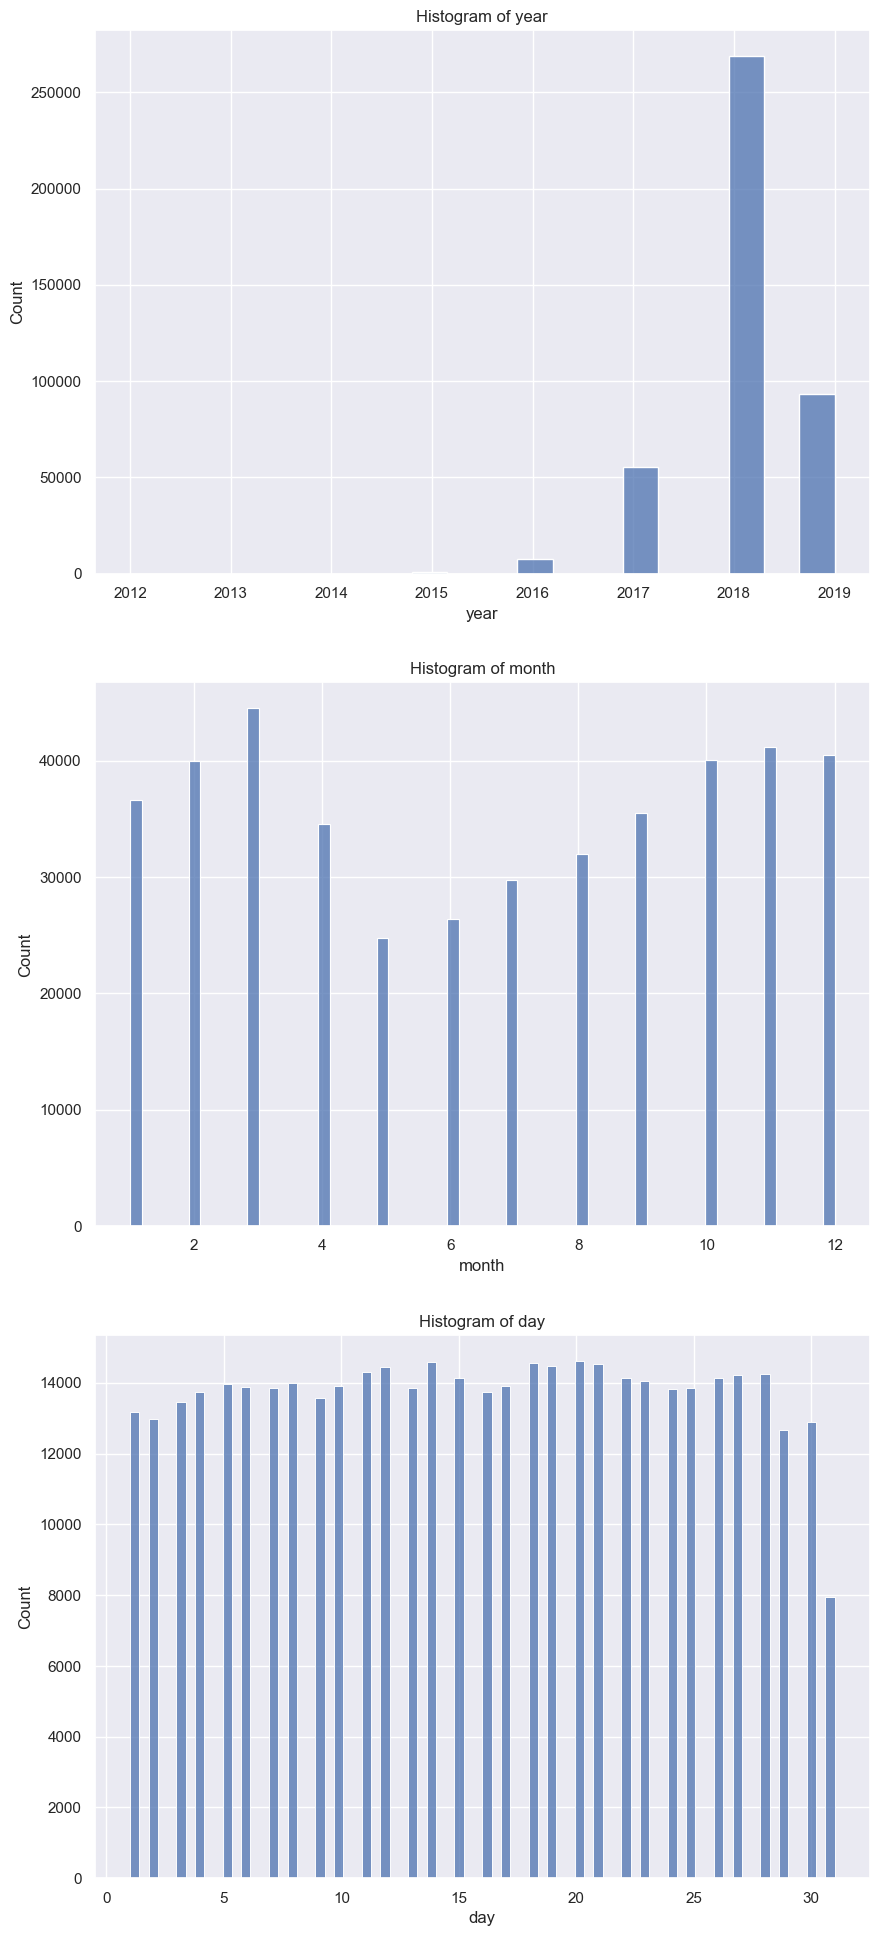

In [86]:
sns.set(font_scale=1)

fig, ax = plt.subplots(3, 1, figsize=(10, 4*6))

sns.histplot(data=df_, x="year", ax=ax[0])
ax[0].title.set_text('Histogram of year')

sns.histplot(data=df_, x="month", ax=ax[1])
ax[1].title.set_text('Histogram of month')

sns.histplot(data=df_, x="day", ax=ax[2])
ax[2].title.set_text('Histogram of day')


plt.show()

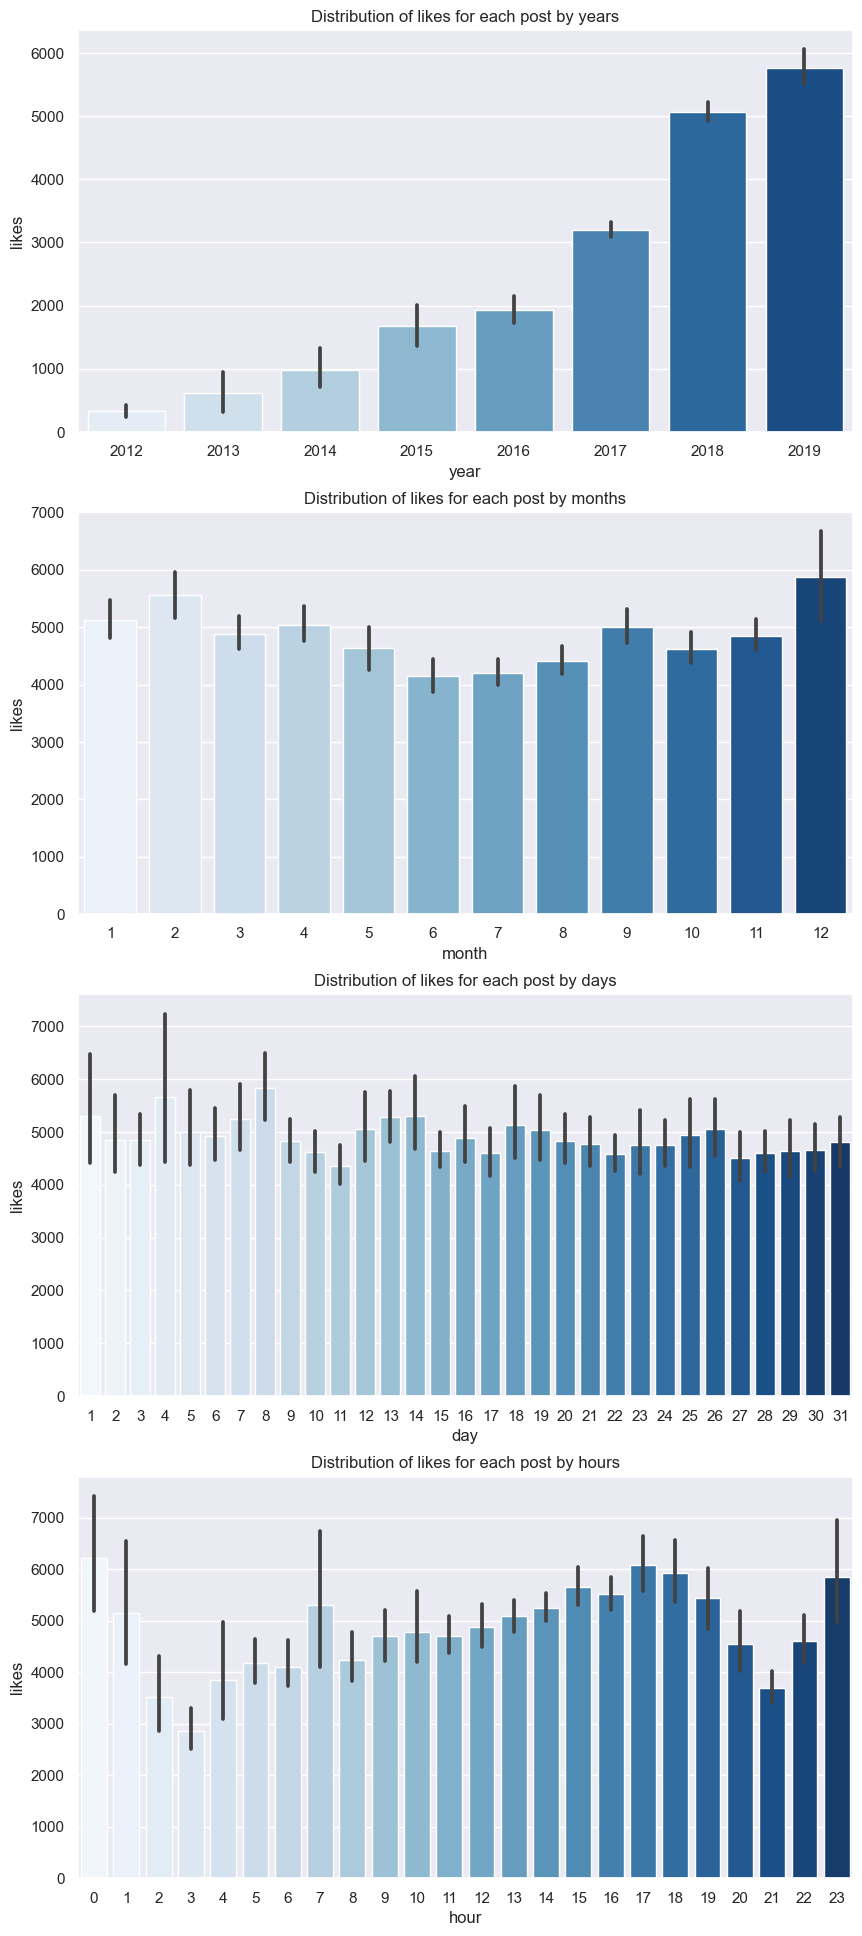

In [87]:
sns.set(font_scale=1)

fig, ax = plt.subplots(4, 1, figsize=(10, 4*6))

sns.barplot(x=df_.year, y=df_.likes, ax=ax[0], palette='Blues')
ax[0].title.set_text('Distribution of likes for each post by years')

sns.barplot(x=df_.month, y=df_.likes, ax=ax[1], palette='Blues')
ax[1].title.set_text('Distribution of likes for each post by months')

sns.barplot(x=df_.day, y=df_.likes, ax=ax[2], palette='Blues')
ax[2].title.set_text('Distribution of likes for each post by days')

sns.barplot(x=df_.hour, y=df_.likes, ax=ax[3], palette='Blues')
ax[3].title.set_text('Distribution of likes for each post by hours')

plt.show()

<Axes: xlabel='year', ylabel='likes'>

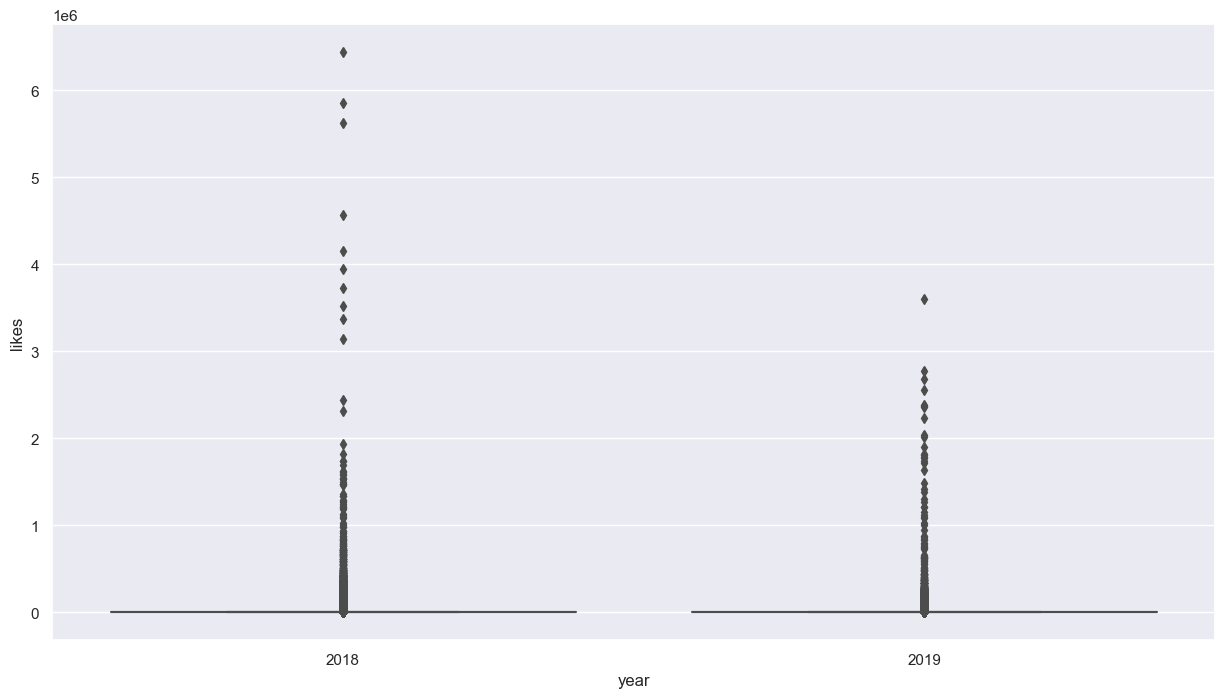

In [88]:
new = df_.loc[df_['year'].isin(toplike['year'].unique())]
plt.figure(figsize=(15,8))
sns.boxplot(x='year', y='likes', data=new)

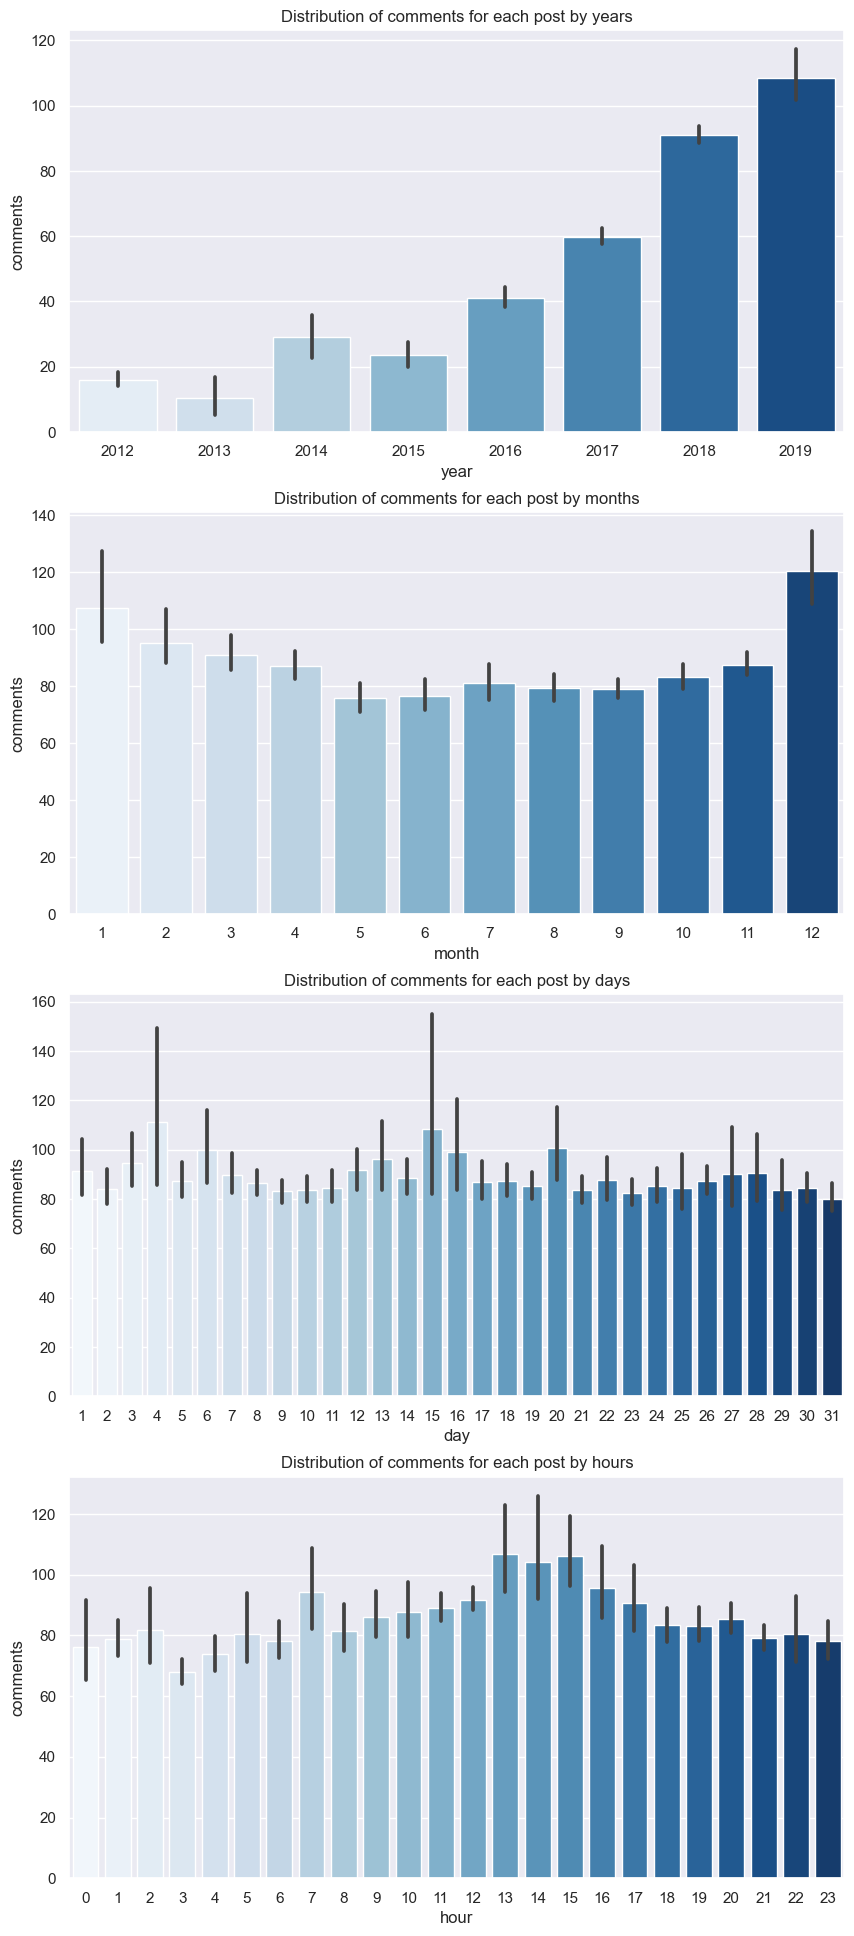

In [89]:
sns.set(font_scale=1)

fig, ax = plt.subplots(4, 1, figsize=(10, 4*6))

sns.barplot(x=df_.year, y=df_.comments, ax=ax[0], palette='Blues')
ax[0].title.set_text('Distribution of comments for each post by years')

sns.barplot(x=df_.month, y=df_.comments, ax=ax[1], palette='Blues')
ax[1].title.set_text('Distribution of comments for each post by months')

sns.barplot(x=df_.day, y=df_.comments, ax=ax[2], palette='Blues')
ax[2].title.set_text('Distribution of comments for each post by days')

sns.barplot(x=df_.hour, y=df_.comments, ax=ax[3], palette='Blues')
ax[3].title.set_text('Distribution of comments for each post by hours')

plt.show()

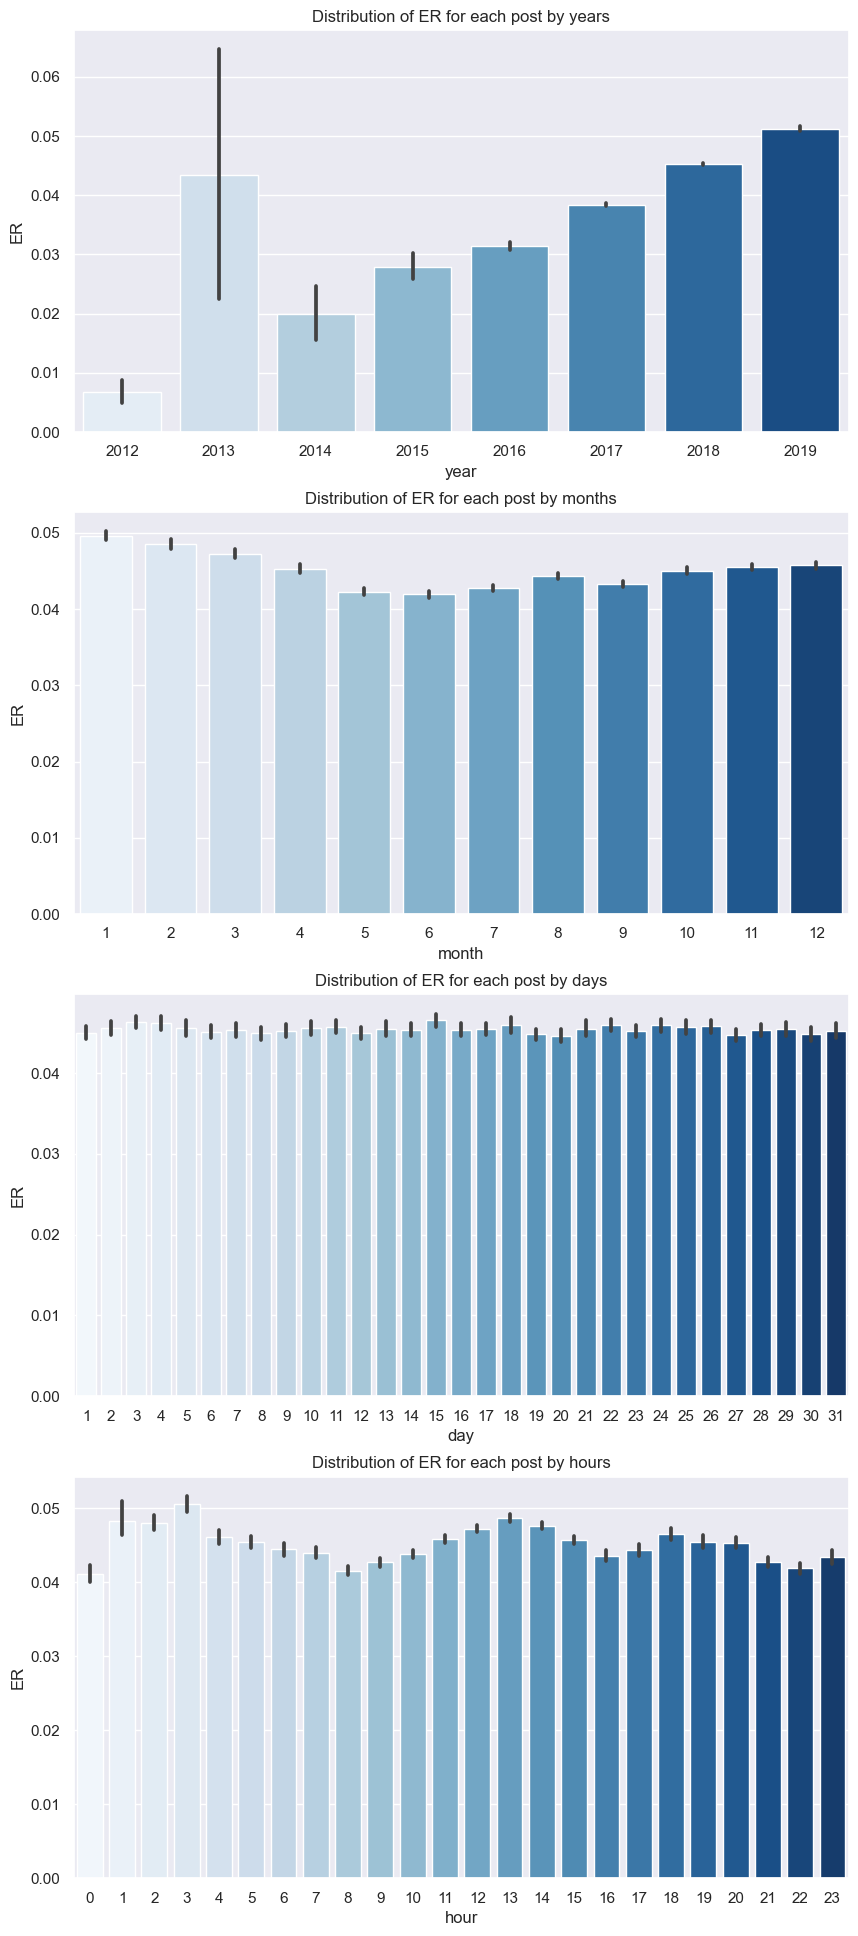

In [90]:
sns.set(font_scale=1)

fig, ax = plt.subplots(4, 1, figsize=(10, 4*6))

sns.barplot(x=df_.year, y=df_.ER, ax=ax[0], palette='Blues')
ax[0].title.set_text('Distribution of ER for each post by years')

sns.barplot(x=df_.month, y=df_.ER, ax=ax[1], palette='Blues')
ax[1].title.set_text('Distribution of ER for each post by months')

sns.barplot(x=df_.day, y=df_.ER, ax=ax[2], palette='Blues')
ax[2].title.set_text('Distribution of ER for each post by days')

sns.barplot(x=df_.hour, y=df_.ER, ax=ax[3], palette='Blues')
ax[3].title.set_text('Distribution of ER for each post by hours')

plt.show()

In [91]:
def plot_agg_simple(agg_name="Average", agg_function=np.mean, ci = 75):
    STEP = 0.1
    plt.figure(figsize=(20, 8))
    frame = df_.groupby('month')['ER'].apply(agg_function)

    sns.lineplot(data=df_, x='month', y='ER', estimator=agg_function, errorbar=('ci', ci), color='#A788B5')
    plt.plot(frame.argmax()+1, frame.max(), color='red', markersize=10, marker='o')
    # plt.text(frame.argmax()+1 + STEP, frame.max(), f'MAX()={round(frame.max())} | {months[frame.argmax()]}', color='red', weight='bold')
    plt.plot(frame.argmin()+1, frame.min(), color='blue', markersize=10, marker='o')
    # plt.text(frame.argmin()+1 + STEP, frame.min(), f'MIN()={round(frame.min())} | {months[frame.argmin()]}', color='blue', weight='bold')
    plt.title(f"{agg_name} number of ER by month ({ci}% confidence interval)")
    plt.show()

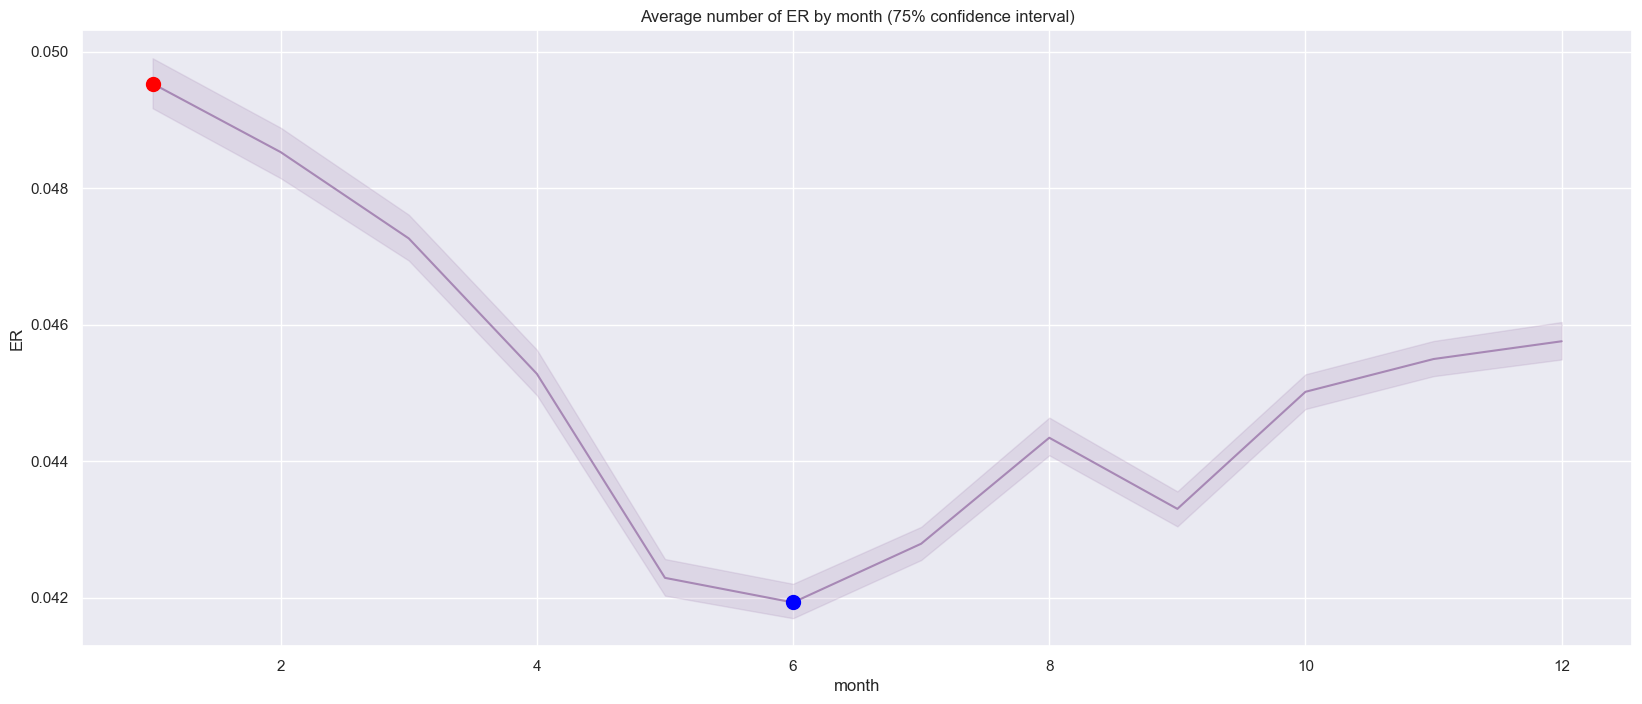

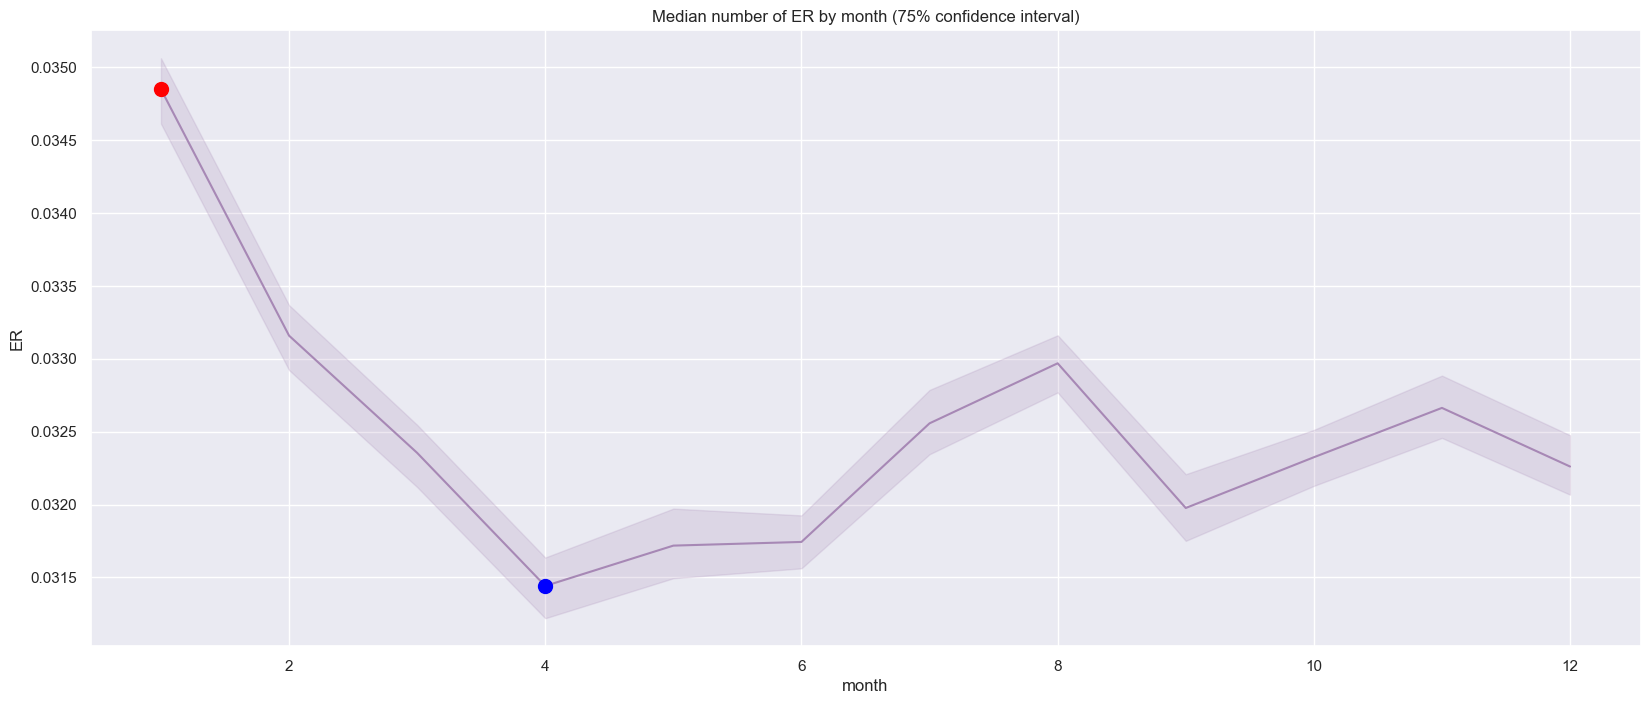

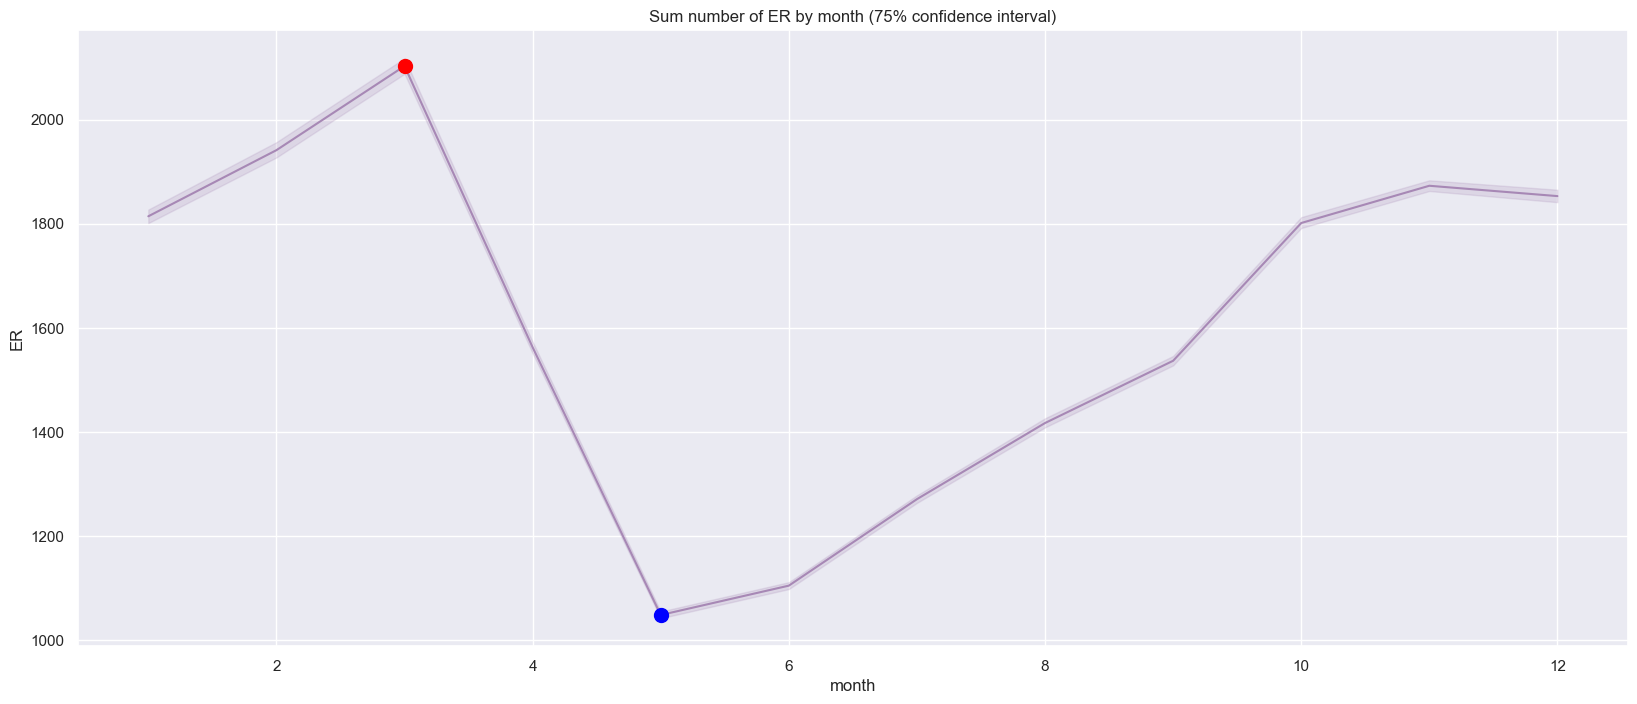

In [92]:
plot_agg_simple(agg_name="Average", agg_function=np.mean, ci=75)
plot_agg_simple(agg_name="Median", agg_function=np.median, ci=75)
plot_agg_simple(agg_name="Sum", agg_function=np.sum, ci=75)

In [93]:
# Correlation between likes and comments
correlation1 = df_['likes'].corr(df_['comments'])
print(f"Correlation between likes and comments: {correlation1}")

# Correlation between ER and likes
correlation2 = df_['ER'].corr(df_['likes'])
print(f"Correlation between ER and likes: {correlation2}")

# Correlation between ER and comments
correlation3 = df_['ER'].corr(df_['comments'])
print(f"Correlation between ER and comments: {correlation3}")

Correlation between likes and comments: 0.31315103459332966
Correlation between ER and likes: 0.046064210650580424
Correlation between ER and comments: 0.09403563557741286
